In [151]:
import os
import json
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.rcParams.update({'font.size': 20})

def linear_fit(x, y):
    x_ = x - x.mean()
    y_ = y - y.mean()
    k = (x_ * y_).sum() / (x_ * x_).sum()
    b = y.mean() - k * x.mean()
    return k, b

IMAGE_DIR = 'images/op-resnet-cifar10/'
os.makedirs(IMAGE_DIR, exist_ok=True)

## Fixed ELR

In [152]:
general_path = '../experiments/resnet32_cifar10_50000obj_ce/'

dirs = os.listdir(general_path)
lrs, wds = [], []
for directory in dirs:
    with open(os.path.join(general_path, directory, 'config.json')) as f:
        config = json.load(f)
        if config['lr'] > 2e-5 and config['lr'] < 0.003:
            lrs.append(config['lr'])
            wds.append(config['wd'])

lrs = np.unique(lrs)
wds = np.unique(wds)
wd_colors = sns.color_palette('viridis', len(wds))
lr_colors = sns.color_palette('plasma', len(lrs))

In [153]:
log_iters = np.array(config['log_iters'])
running_log_iters = np.arange(0, config['num_iters'], config['running_log_freq'])
shape = (len(lrs), len(wds), len(log_iters))
train_losses = np.zeros(shape)
stoch_grad_rms = np.zeros(shape)
full_grad_norms = np.zeros(shape)
spherical_entropies = np.zeros(shape)
log_radii = np.zeros(shape)
mean_radii = np.zeros(shape)
running_radii = np.zeros((len(lrs), len(wds), len(running_log_iters)))

for i, lr in enumerate(lrs):
    for j, wd in enumerate(wds):
        path = general_path+f'lr{lr:.2e}_wd{wd:.2e}_seed1/trace.pt'
        trace = torch.load(path, map_location=torch.device('cpu'), weights_only=False)
        try:
            train_losses[i, j] = np.array(trace['trace']['train_loss'])
            stoch_grad_rms[i, j] = np.array(trace['trace']['stoch_grad_rms'])
            full_grad_norms[i, j] = np.array(trace['trace']['full_grad_norm'])
            spherical_entropies[i, j] = np.array(trace['trace']['spherical_entropy'])
            log_radii[i, j] = np.array(trace['trace']['log_radius'])
            mean_radii[i, j] = np.array(trace['trace']['mean_radius'])
            running_radii[i, j] = np.array(trace['trace']['running_radius'])
        except:
            print(f'No checkpoint for LR={lr:.2e}, WD={wd:.2e}')

full_entropies = spherical_entropies + log_radii
covariance_traces = stoch_grad_rms ** 2 * mean_radii ** 2
full_gn_sq = full_grad_norms ** 2 * mean_radii ** 2

In [159]:
D = 0
for key, param in trace['model'].items():
    if 'linear' not in key and 'bn' not in key and 'shortcut.0' not in key:
        D += param.numel()
D

2790240

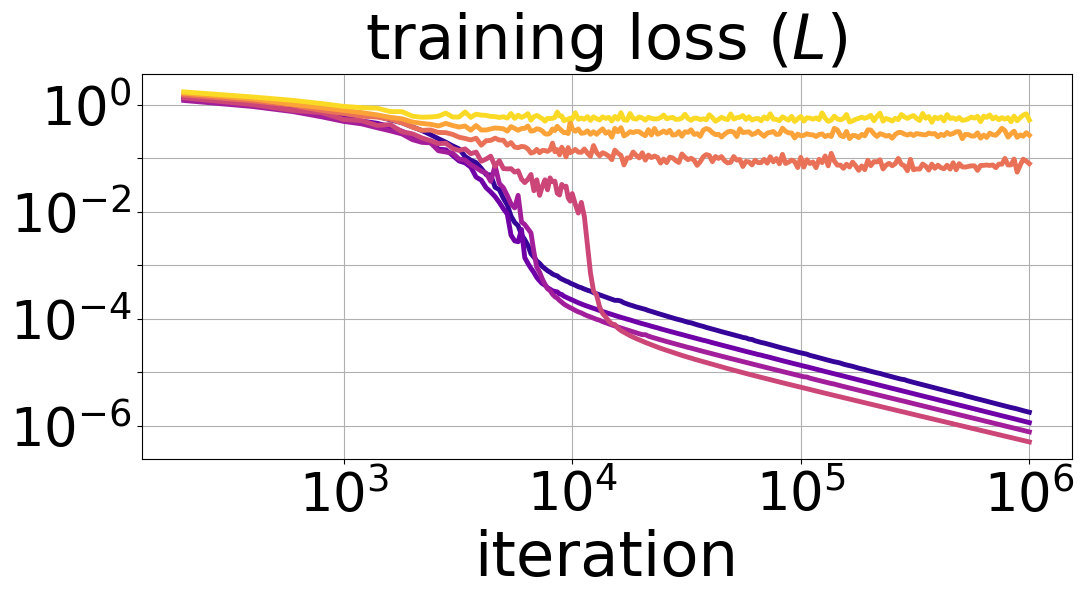

In [187]:
plt.figure(figsize=(12, 5))
plt.tight_layout()

for i in range(0, len(lrs), 2):
    plt.plot(log_iters, train_losses[i, 0], color=lr_colors[i], linewidth=3.5)

plt.xscale('log')
plt.yscale('log')
plt.xticks([1e+3, 1e+4, 1e+5, 1e+6], ['$10^{3}$', '$10^{4}$', '$10^{5}$', '$10^{6}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0], ['$10^{-6}$', '', '$10^{-4}$', '', '$10^{-2}$', '', '$10^{0}$'], fontsize=38)
plt.yticks([], [], minor=True)
plt.xlabel(r'iteration', fontsize=45)
plt.title(r'training loss ($L$)', fontsize=45, y=1.02)
plt.grid()
plt.savefig(f'{IMAGE_DIR}ELR-loss.png', dpi=400, bbox_inches='tight')

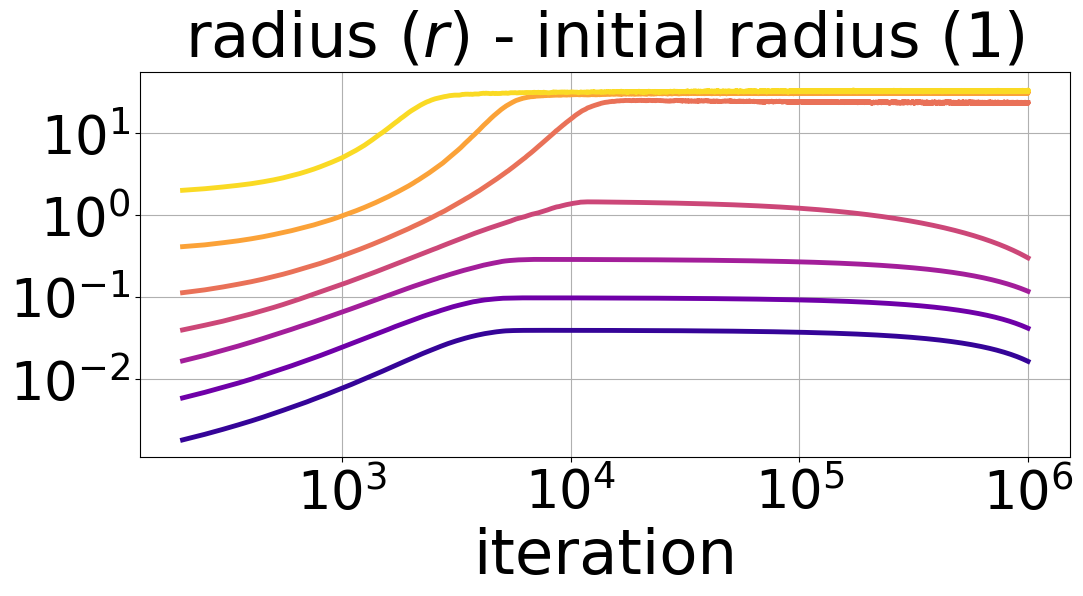

In [188]:
plt.figure(figsize=(12, 5))
plt.tight_layout()

for i in range(0, len(lrs), 2):
    plt.plot(running_log_iters[running_log_iters >= log_iters.min()],
             running_radii[i, 0, running_log_iters >= log_iters.min()] - 1, color=lr_colors[i], linewidth=3.5)

plt.xscale('log')
plt.yscale('log')
plt.xticks([1e+3, 1e+4, 1e+5, 1e+6], ['$10^{3}$', '$10^{4}$', '$10^{5}$', '$10^{6}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([1e-2, 1e-1, 1e0, 1e+1], ['$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$'], fontsize=38)
plt.yticks([], [], minor=True)
plt.xlabel(r'iteration', fontsize=45)
plt.title(r'radius ($r$) - initial radius ($1$)', fontsize=45, y=1.02)
plt.grid()
plt.savefig(f'{IMAGE_DIR}ELR-radius.png', dpi=400, bbox_inches='tight')

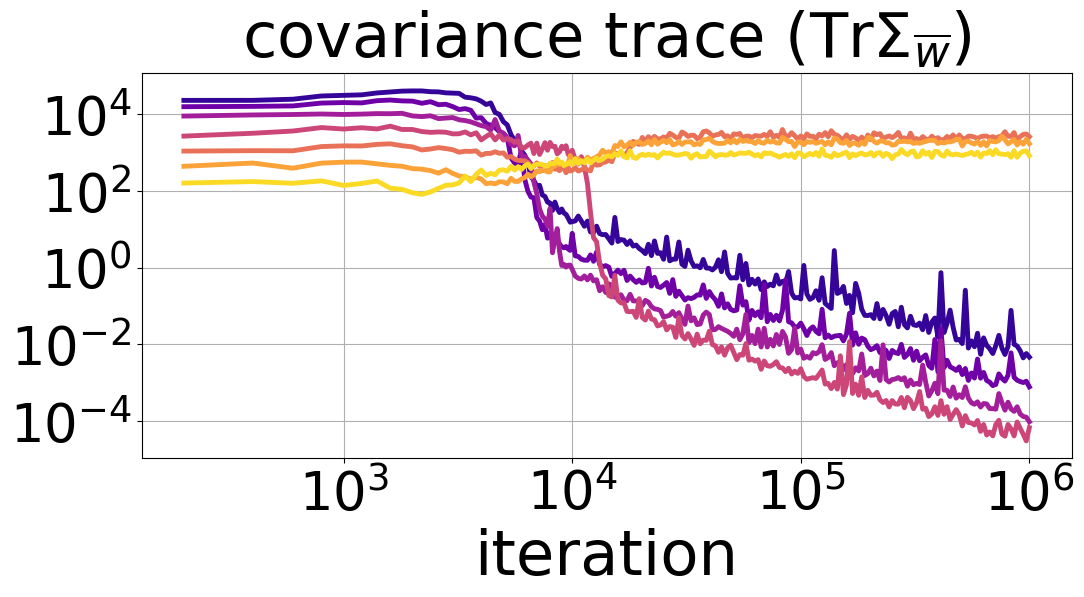

In [189]:
plt.figure(figsize=(12, 5))
plt.tight_layout()

for i in range(0, len(lrs), 2):
    plt.plot(log_iters, covariance_traces[i, 0], color=lr_colors[i], linewidth=3.5)

plt.xscale('log')
plt.yscale('log')
plt.xticks([1e+3, 1e+4, 1e+5, 1e+6], ['$10^{3}$', '$10^{4}$', '$10^{5}$', '$10^{6}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([1e-4, 1e-2, 1e-0, 1e+2, 1e+4], ['$10^{-4}$', '$10^{-2}$', '$10^{0}$', '$10^{2}$', '$10^{4}$'], fontsize=38)
plt.yticks([], [], minor=True)
plt.xlabel(r'iteration', fontsize=45)
plt.title(r'covariance trace ($\text{Tr} \Sigma_{\overline{w}}$)', fontsize=45, y=1.02)
plt.grid()
plt.savefig(f'{IMAGE_DIR}ELR-covariance.png', dpi=400, bbox_inches='tight')

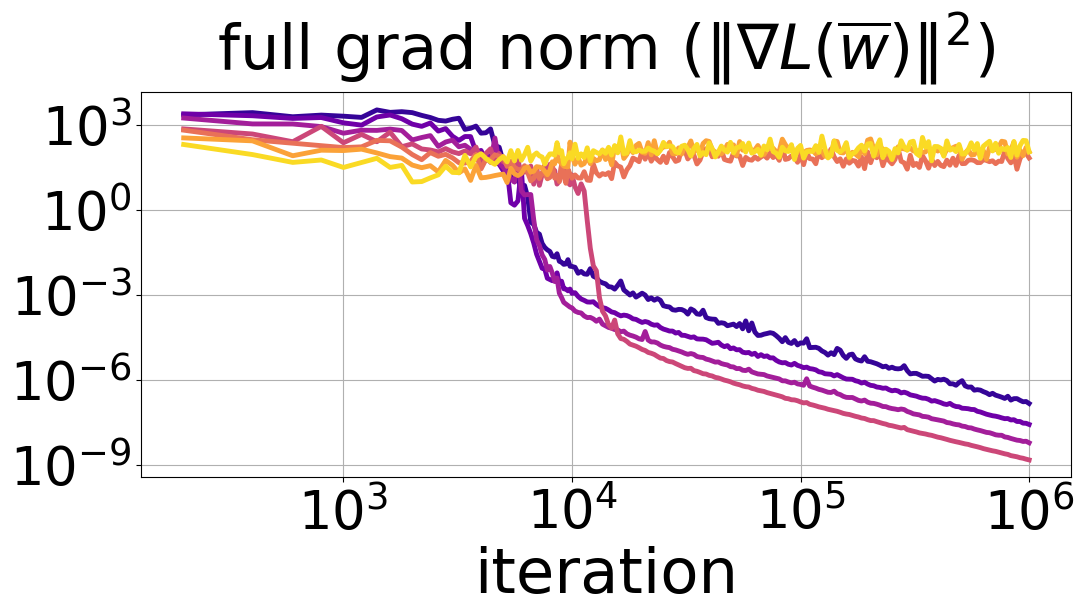

In [190]:
plt.figure(figsize=(12, 5))
plt.tight_layout()

for i in range(0, len(lrs), 2):
    plt.plot(log_iters, full_gn_sq[i, 0], color=lr_colors[i], linewidth=3.5)

plt.xscale('log')
plt.yscale('log')
plt.xticks([1e+3, 1e+4, 1e+5, 1e+6], ['$10^{3}$', '$10^{4}$', '$10^{5}$', '$10^{6}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([1e-9, 1e-6, 1e-3, 1e-0, 1e+3], ['$10^{-9}$', '$10^{-6}$', '$10^{-3}$', '$10^{0}$', '$10^{3}$'], fontsize=38)
plt.yticks([], [], minor=True)
plt.xlabel(r'iteration', fontsize=45)
plt.title(r'full grad norm ($\|\nabla L(\overline{w})\|^2$)', fontsize=45, y=1.04)
plt.grid()
plt.savefig(f'{IMAGE_DIR}ELR-grad.png', dpi=400, bbox_inches='tight')

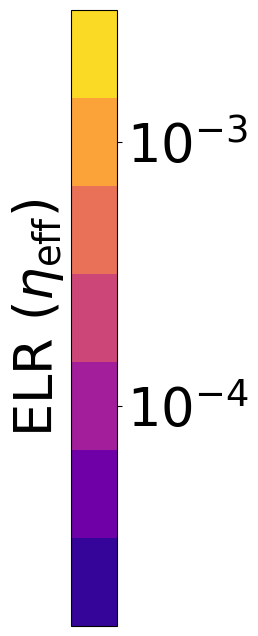

In [177]:
import matplotlib as mpl

cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_plasma", lr_colors[::2], N=len(lr_colors[::2]))
fig, ax = plt.subplots(figsize=(0.6, 8))
norm = mpl.colors.Normalize(vmin=0, vmax=len(lr_colors[::2]))
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')
#cb.set_ticks(np.arange(0.5, 7.4, 1))
#cb.set_ticklabels([r'$2.2 \cdot 10^{-5}$', r'$4.6 \cdot 10^{-5}$', r'$10^{-4}$',
#                   r'$2.2 \cdot 10^{-4}$', r'$4.6 \cdot 10^{-4}$', r'$10^{-3}$', r'$2.2 \cdot 10^{-3}$'], fontsize=38)
cb.set_ticks([2.5, 5.5])
cb.set_ticklabels([r'$10^{-4}$', r'$10^{-3}$'], fontsize=38)
cb.set_label('')
ax.text(-0.1, 0.5, r'ELR ($\eta_{\text{eff}}$)', fontsize=38, transform=ax.transAxes,
        rotation=90, va='center', ha='right')

plt.savefig(f'{IMAGE_DIR}ELR-legend1.png', dpi=400, bbox_inches='tight')